In [275]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Chargement Dataset

In [276]:
df  = pd.read_pickle("df_balanced.pkl")


## Apercu des valeurs 

In [277]:
df.head()

,id,keyword,location,text,target,presence_location,presence_keyword,char_count,word_count,stopword_count,...,punctuation_count,hashtag_count,mention_count,clean_text,clean_location,clean_keyword,tokens,version_stop,version_stem,version_lemma
6818,9765,trapped,10 Steps Ahead. Cloud 9,Bomb head? Explosive decisions dat produced mo...,1,1,1,134,21,6,...,1,0,0,bomb head explosive decisions dat produced mor...,steps ahead cloud,trapped,"[bomb, head, explosive, decisions, dat, produc...",bomb head explosive decisions dat produced dea...,bomb head explos decis dat produc dead childre...,bomb head explosive decision dat produced dead...
4842,6896,mass%20murder,"Huntsville, AL",Okay not sure the word 'mass murder' applies d...,1,1,1,121,19,9,...,8,0,0,okay not sure the word mass murder applies dur...,huntsville al,massmurder,"[okay, sure, word, mass, murder, applies, war,...",okay sure word mass murder applies war horrend...,okay sure word mass murder appli war horrend n...,okay sure word mass murder applies war horrend...
5848,8356,ruin,Garrett,like why on earth would you want anybody to be...,0,1,1,101,17,6,...,2,0,0,like why on earth would you want anybody to be...,garrett,ruin,"[like, earth, would, want, anybody, unhappy, d...",like earth would want anybody unhappy dont pur...,like earth would want anybodi unhappi dont pur...,like earth would want anybody unhappy dont pur...
1851,2661,crush,"Cleveland, Ohio",My woman crush wedneday goes to the beautiful ...,0,1,1,108,12,3,...,8,2,1,my woman crush wedneday goes to the beautiful,cleveland ohio,crush,"[woman, crush, wedneday, goes, beautiful]",woman crush wedneday goes beautiful,woman crush wedneday goe beauti,woman crush wedneday go beautiful
5729,8176,rescuers,Washington,#News: 'Many deaths' in shipwreck: Rescuers ar...,1,1,1,136,18,6,...,14,1,1,many deaths in shipwreck rescuers are trying t...,washington,rescuers,"[many, deaths, shipwreck, rescuers, trying, sa...",many deaths shipwreck rescuers trying save hun...,mani death shipwreck rescuer tri save hundr mi...,many death shipwreck rescuer trying save hundr...


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, 6818 to 2019
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4392 non-null   int64  
 1   keyword            4392 non-null   object 
 2   location           4392 non-null   object 
 3   text               4392 non-null   object 
 4   target             4392 non-null   int64  
 5   presence_location  4392 non-null   int64  
 6   presence_keyword   4392 non-null   int64  
 7   char_count         4392 non-null   int64  
 8   word_count         4392 non-null   int64  
 9   stopword_count     4392 non-null   int64  
 10  unique_word_count  4392 non-null   int64  
 11  stop_word_count    4392 non-null   int64  
 12  url_count          4392 non-null   int64  
 13  mean_word_length   4392 non-null   float64
 14  punctuation_count  4392 non-null   int64  
 15  hashtag_count      4392 non-null   int64  
 16  mention_count      4392 no

In [279]:
nb_uniques = df["clean_keyword"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["clean_keyword"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots clés uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots clés uniques : 221
Pourcentage de cellules remplies : 100.00%


In [280]:
nb_uniques = df["clean_location"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["clean_location"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots location uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots location uniques : 2570
Pourcentage de cellules remplies : 100.00%


In [281]:
print(df.shape)

(4392, 24)


## EDA


In [282]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

In [283]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)


# Extraction des top mots
top_words_0 = get_top_words(df_0["clean_keyword"], 50)
top_words_1 = get_top_words(df_1["clean_keyword"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,ruin,22,outbreak,30
1,harm,21,wreckage,28
2,blight,21,oilspill,27
3,deluge,21,collision,26
4,armageddon,21,derailment,25
5,blewup,20,buildingsonfire,25
6,mayhem,19,evacuated,25
7,inundated,19,earthquake,24
8,fear,19,airplaneaccident,24
9,screaming,19,sandstorm,24


In [284]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["clean_location"], 50)
top_words_1 = get_top_words(df_1["clean_location"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,102,usa,137
1,usa,99,new,80
2,york,76,ca,60
3,ca,62,united,44
4,london,53,washington,43
5,united,45,nigeria,43
6,ny,41,york,43
7,england,40,uk,42
8,uk,39,canada,42
9,city,37,california,40


In [285]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["clean_text"], 50)
top_words_1 = get_top_words(df_1["clean_text"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,im,137,police,80
1,like,122,amp,75
2,just,118,people,67
3,new,108,like,66
4,amp,97,disaster,66
5,dont,70,pm,64
6,body,60,buildings,63
7,emergency,50,just,63
8,video,49,suicide,61
9,people,48,killed,60


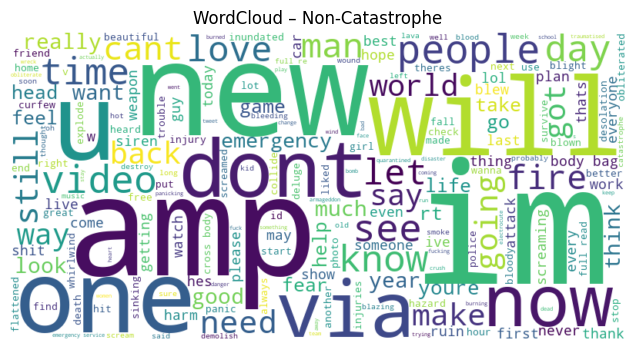

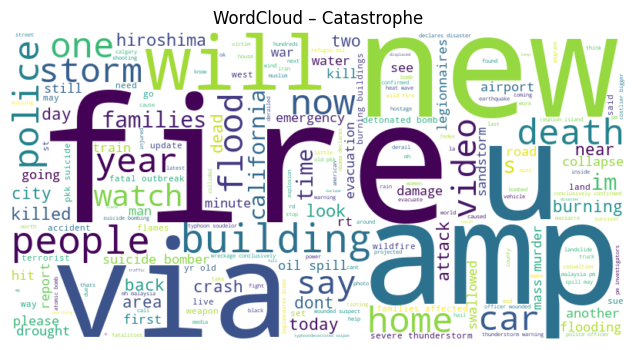

In [286]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["clean_text"])
text_1 = " ".join(df_1["clean_text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

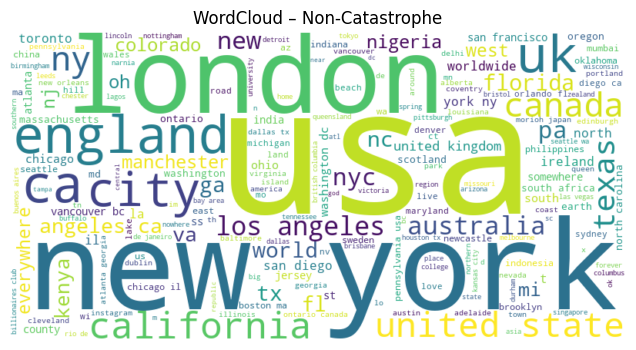

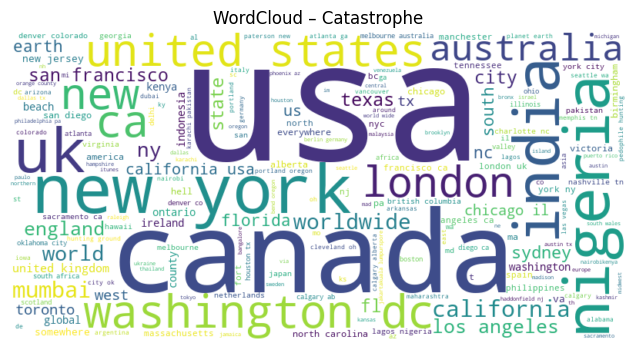

In [287]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["clean_location"])
text_1 = " ".join(df_1["clean_location"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


## Analyse des features

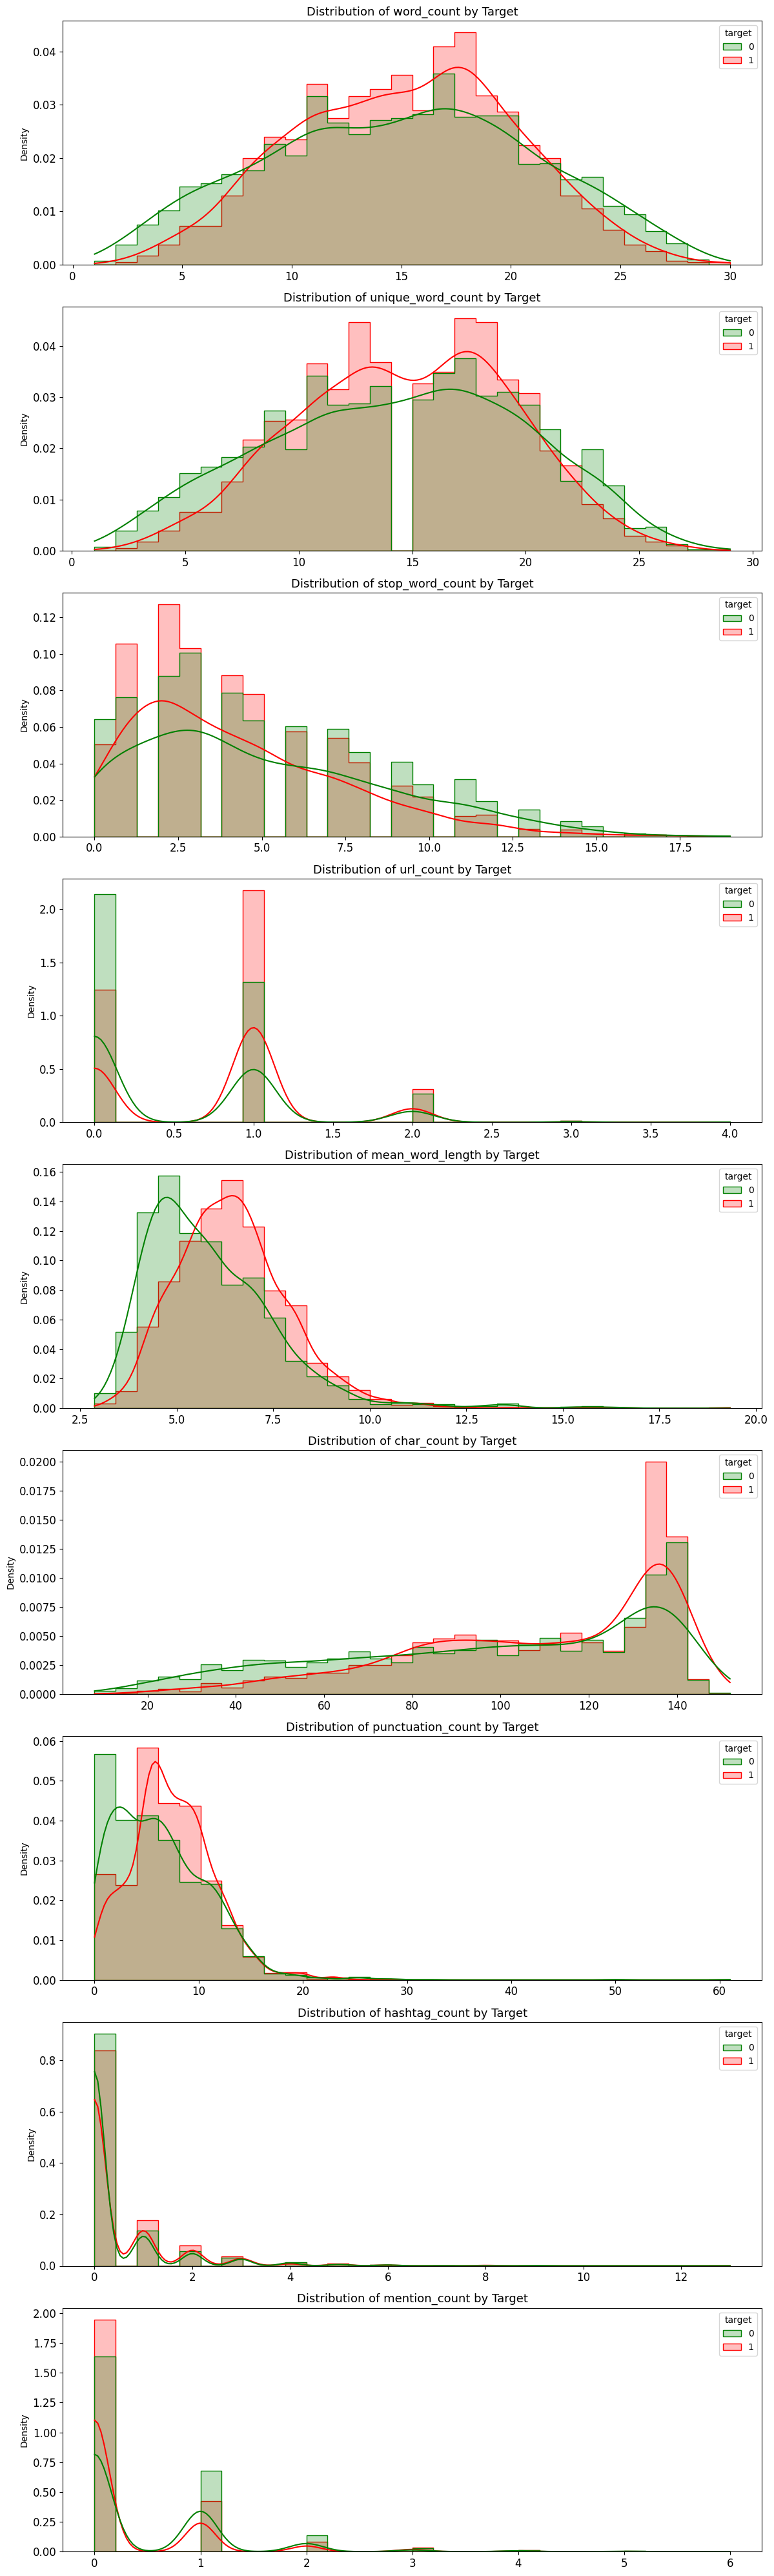

In [288]:
# Liste des features à analyser
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count',
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# Filtre pour les tweets liés à des catastrophes
DISASTER_TWEETS = df['target'] == 1

# Création de la figure avec sous-graphiques
fig, axes = plt.subplots(nrows=len(METAFEATURES), ncols=1, figsize=(12, 40), dpi=100)

# Pour chaque feature, on trace deux courbes : disaster vs non-disaster
for i, feature in enumerate(METAFEATURES):
    sns.histplot(data=df, x=feature, hue='target', kde=True, ax=axes[i], bins=30,
                 palette={0: "green", 1: "red"}, element="step", stat="density")
    
    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

In [289]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_words[:top_n], columns=['ngram', 'count'])

In [290]:
def plot_all_ngrams(df, target_value):
    text_data = df[df['target'] == target_value]['clean_text']

    bigrams = get_top_ngrams(text_data, ngram_range=(2, 2), top_n=20)
    trigrams = get_top_ngrams(text_data, ngram_range=(3, 3), top_n=20)
    quadgrams = get_top_ngrams(text_data, ngram_range=(4, 4), top_n=20)

    fig, axes = plt.subplots(1, 3, figsize=(22, 10))

    for ax, data, title in zip(
        axes,
        [bigrams, trigrams, quadgrams],
        ['Bigrammes', 'Trigrammes', 'Quadgrammes']
    ):
        ngram_df = pd.DataFrame(data, columns=['ngram', 'count'])
        sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
        ax.set_title(f"{title} pour target = {target_value}")
        ax.set_xlabel("Fréquence")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

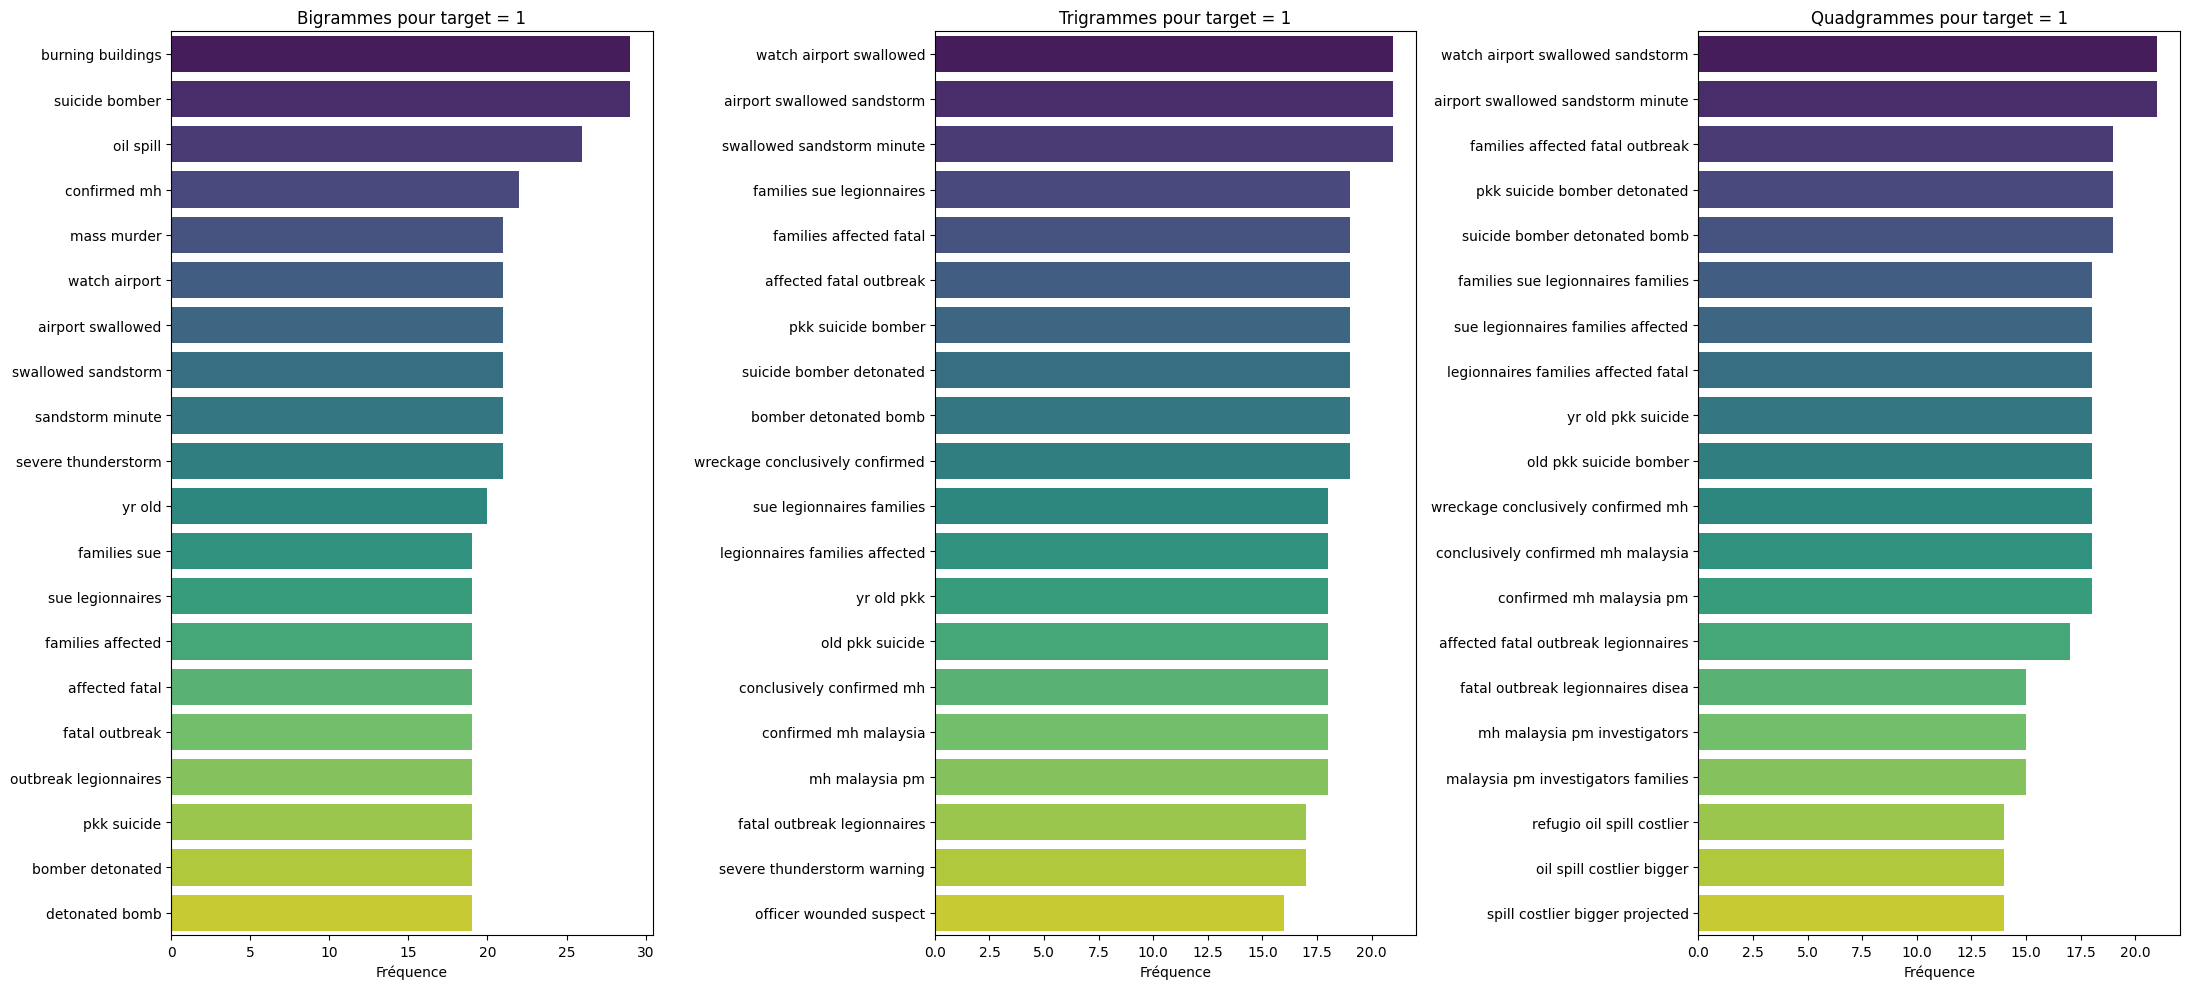

/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

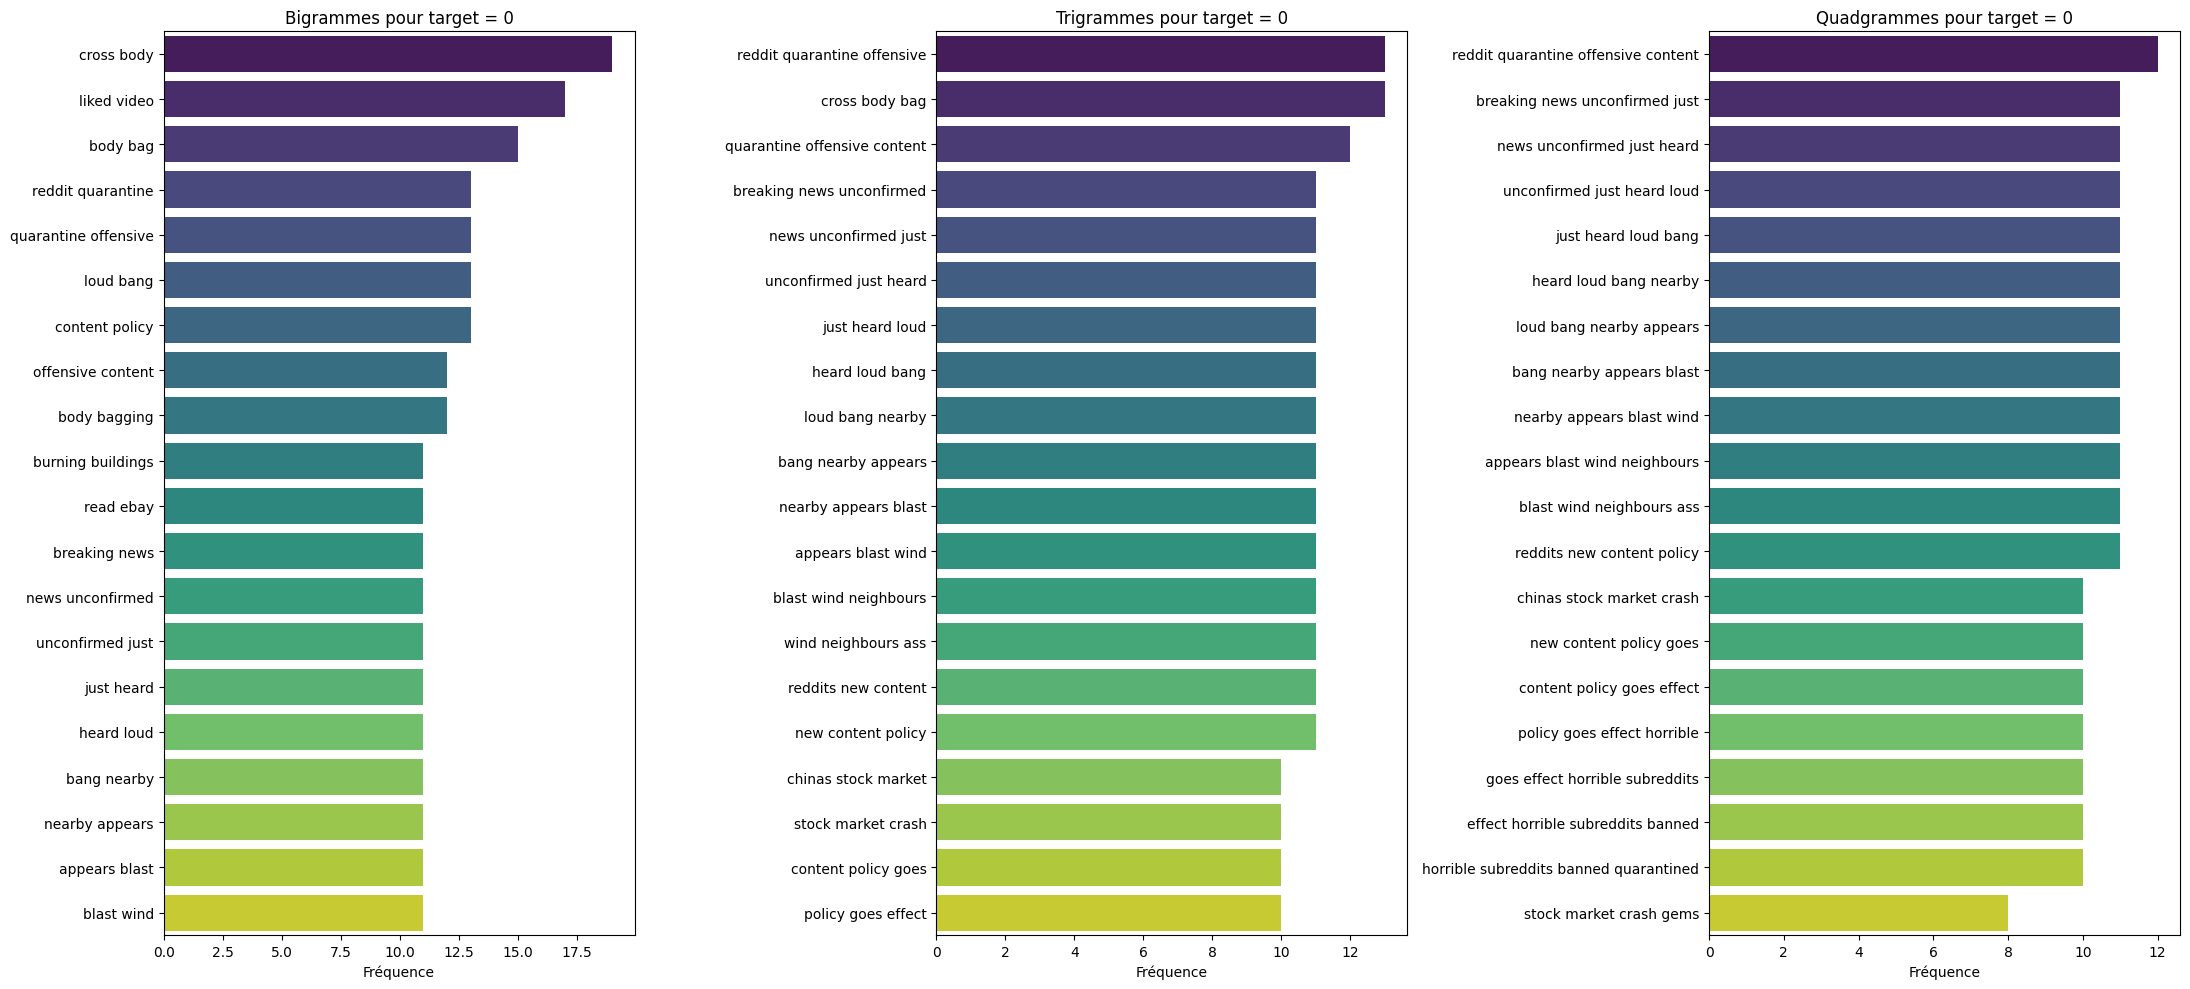

In [291]:
plot_all_ngrams(df, 1)  # Pour les tweets de catastrophe
plot_all_ngrams(df, 0)  # Pour les autres


In [292]:
df.head()

,id,keyword,location,text,target,presence_location,presence_keyword,char_count,word_count,stopword_count,...,punctuation_count,hashtag_count,mention_count,clean_text,clean_location,clean_keyword,tokens,version_stop,version_stem,version_lemma
6818,9765,trapped,10 Steps Ahead. Cloud 9,Bomb head? Explosive decisions dat produced mo...,1,1,1,134,21,6,...,1,0,0,bomb head explosive decisions dat produced mor...,steps ahead cloud,trapped,"[bomb, head, explosive, decisions, dat, produc...",bomb head explosive decisions dat produced dea...,bomb head explos decis dat produc dead childre...,bomb head explosive decision dat produced dead...
4842,6896,mass%20murder,"Huntsville, AL",Okay not sure the word 'mass murder' applies d...,1,1,1,121,19,9,...,8,0,0,okay not sure the word mass murder applies dur...,huntsville al,massmurder,"[okay, sure, word, mass, murder, applies, war,...",okay sure word mass murder applies war horrend...,okay sure word mass murder appli war horrend n...,okay sure word mass murder applies war horrend...
5848,8356,ruin,Garrett,like why on earth would you want anybody to be...,0,1,1,101,17,6,...,2,0,0,like why on earth would you want anybody to be...,garrett,ruin,"[like, earth, would, want, anybody, unhappy, d...",like earth would want anybody unhappy dont pur...,like earth would want anybodi unhappi dont pur...,like earth would want anybody unhappy dont pur...
1851,2661,crush,"Cleveland, Ohio",My woman crush wedneday goes to the beautiful ...,0,1,1,108,12,3,...,8,2,1,my woman crush wedneday goes to the beautiful,cleveland ohio,crush,"[woman, crush, wedneday, goes, beautiful]",woman crush wedneday goes beautiful,woman crush wedneday goe beauti,woman crush wedneday go beautiful
5729,8176,rescuers,Washington,#News: 'Many deaths' in shipwreck: Rescuers ar...,1,1,1,136,18,6,...,14,1,1,many deaths in shipwreck rescuers are trying t...,washington,rescuers,"[many, deaths, shipwreck, rescuers, trying, sa...",many deaths shipwreck rescuers trying save hun...,mani death shipwreck rescuer tri save hundr mi...,many death shipwreck rescuer trying save hundr...


target               1.000000
url_count            0.190229
mean_word_length     0.180518
char_count           0.165390
punctuation_count    0.120589
hashtag_count        0.045065
unique_word_count    0.033586
word_count           0.022410
mention_count       -0.108628
stop_word_count     -0.118003
presence_location         NaN
presence_keyword          NaN
Name: target, dtype: float64


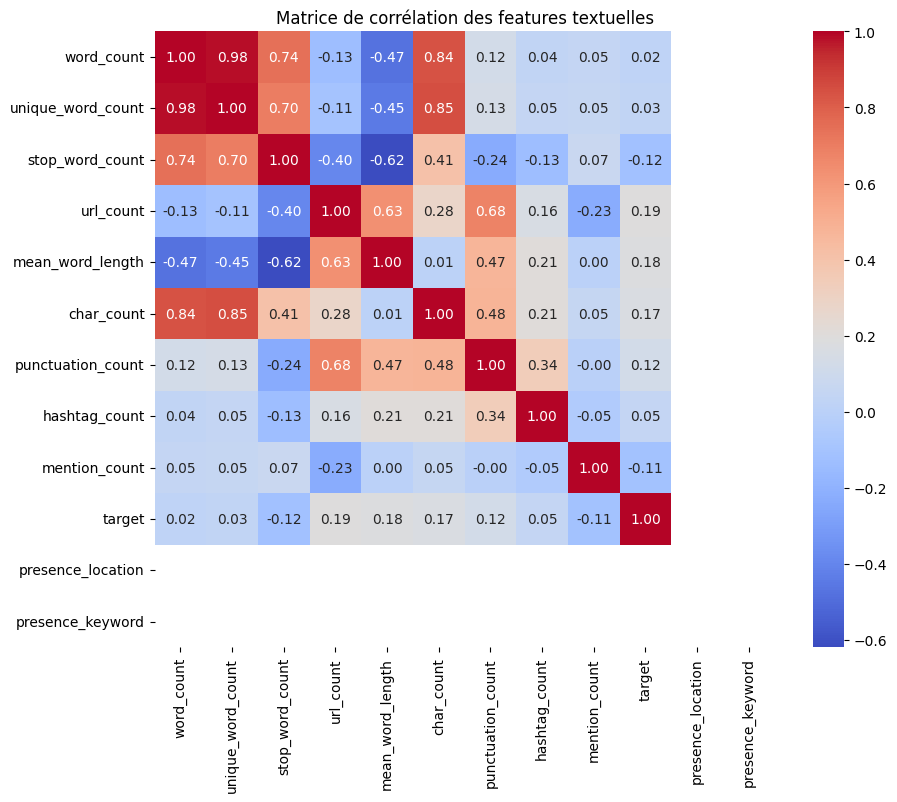

In [ ]:

features = [
    'word_count', 'unique_word_count', 'stop_word_count', 'url_count',
    'mean_word_length', 'char_count', 'punctuation_count', 
    'hashtag_count', 'mention_count', 'target'
]

corr_matrix = df[features].corr()
print(corr_matrix["target"].sort_values(ascending=False))


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des features textuelles")
plt.show()


In [295]:
df_raw = pd.read_pickle("df.pkl")  # ou autre fichier avant le balancing

df_raw["presence_location"] = df_raw["location"].notnull().astype(int)
df_raw["presence_keyword"] = df_raw["keyword"].notnull().astype(int)

# % de tweets de catastrophe selon presence
print(df_raw.groupby("presence_location")["target"].mean())
print(df_raw.groupby("presence_keyword")["target"].mean())

presence_location
0    0.424398
1    0.432283
Name: target, dtype: float64
presence_keyword
0    0.688525
1    0.427569
Name: target, dtype: float64


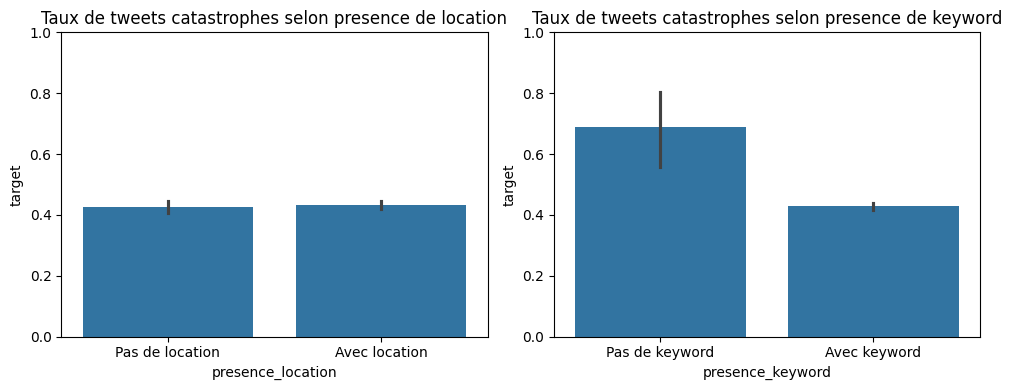

In [296]:
 plt.figure(figsize=(10, 4))

# Presence de location
plt.subplot(1, 2, 1)
sns.barplot(x="presence_location", y="target", data=df_raw)
plt.title("Taux de tweets catastrophes selon presence de location")
plt.ylim(0, 1)
plt.xticks([0, 1], ["Pas de location", "Avec location"])

# Presence de keyword
plt.subplot(1, 2, 2)
sns.barplot(x="presence_keyword", y="target", data=df_raw)
plt.title("Taux de tweets catastrophes selon presence de keyword")
plt.ylim(0, 1)
plt.xticks([0, 1], ["Pas de keyword", "Avec keyword"])

plt.tight_layout()
plt.show()
